In [1]:
###### Applications Lab #1-- ATOC7500 Objective Analysis
##### Originally coded by Prof. Jennifer Kay (CU) with input from Elizabeth Maroon (CU ATOC/CIRES Postdoc 2018)
##### last updated September 2, 2020

###LEARNING GOALS:
###1) Working in an ipython notebook: read in netcdf file, make line plots and histograms
###2) Calculate statistical significance of the changes in the normalized mean using a z-statistic and a t-statistic
###3) Calculate confidence intervals on CESM-LE global warming using z-statistic and t-statistic

# Import the packages and general set-up
%matplotlib inline  
# this enables plotting within notebook
import matplotlib   # library for plotting
import matplotlib.pyplot as plt # basic plotting; later you will type plt.$COMMAND
import numpy as np # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html  
import xarray  ##netcdf manipulation - slick array manipulation

In [2]:
## LEARNING GOAL #1
## Read in the data from netcdf files
## These data are global annual mean surface temperatures from the 
## CESM Large Ensemble Project (https://doi.org/10.1175/BAMS-D-13-00255.1.
fname="TS_timeseries_cesmle_1920_2100.nc"
ds=xarray.open_dataset(fname)
#ds  ## note: uncommenting this line prints information about the data you read in
fname1="TS_timeseries_cesmle_1850.nc"
ds1=xarray.open_dataset(fname1)
gts=ds["gts_ann_allcesmle"]
ats=ds["ats_ann_allcesmle"]
year=ds["year"]
#gts  ## note: uncommenting this line prints information about the variable gts
gts_1850=ds1["gts_annual"]

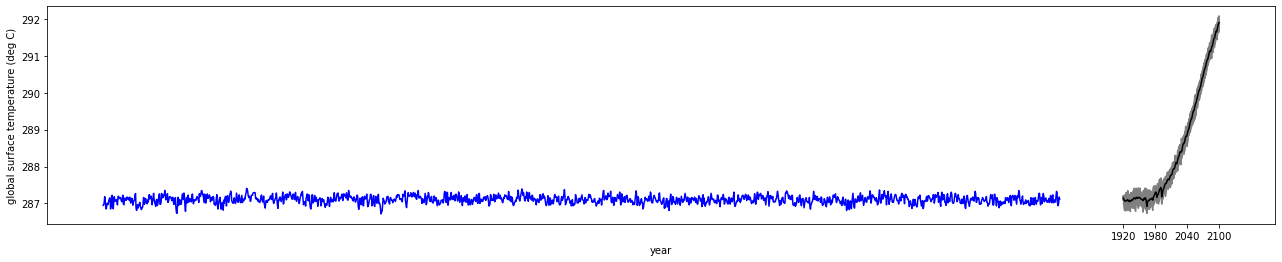

In [3]:
## It's always a good idea to plot your data before you start doing any calculations.  "Look at your data"!
## Let's make a quick line plot of global annual mean temperature timeseries 
## from the 1850 control and the ensemble members.
plt.rcParams["figure.figsize"] = [22,4]
[plt.plot(year,gts.sel(member=i),color="grey") for i in range(1,31)] ## plot all ensemble members
plt.plot(year,gts.mean("member"),color="black")  ## plot ensemble mean
plt.xlabel('year')
plt.ylabel('global surface temperature (deg C)')
plt.xticks(np.arange(1920,2101,60),["1920","1980","2040","2100"])

plt.plot(gts_1850,color="blue");  ## add ";" to not print to screen plotting comments

In [4]:
## LEARNING GOAL #2 - Assess global warming in the ensemble and compare it to the 1850 control with constant forcing

#### With the 1850 control we have the opportunity to calculate population statistics with constant forcing.
#### Let's find the population mean and population standard deviation from the 1850 control.  
gts_1850_mean=np.mean(gts_1850)
gts_1850_std=np.std(gts_1850)
print("Mean 1850 global mean surface temperature")
print(np.str(np.round(gts_1850_mean.values,2)))
print("Standard deviation in 1850 global mean surface temperature:")
print(np.str(np.round(gts_1850_std.values,2)))

Mean 1850 global mean surface temperature
287.11
Standard deviation in 1850 global mean surface temperature:
0.1


Standardized mean and std in 1850 global mean surface temperature:
0.0
1.0


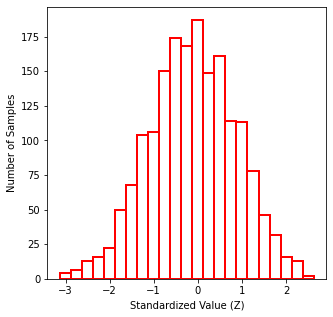

In [5]:
#### Standardize the data and plot a histogram
gts_1850_norm=(gts_1850-gts_1850_mean)/gts_1850_std
gts_1850_norm_mean=np.mean(gts_1850_norm).values
gts_1850_norm_std=np.std(gts_1850_norm).values
print("Standardized mean and std in 1850 global mean surface temperature:")
print(np.str(np.round(gts_1850_norm_mean,2)))
print(np.str(np.round(gts_1850_norm_std,2)))

xinc = np.arange(-3,3,.25)
hx=np.histogram(gts_1850_norm,xinc)
plt.rcParams["figure.figsize"] = [5,5]
plt.bar(hx[1][:-1],hx[0],edgecolor = 'r', color = [], width = .25, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

## another histogram option to try (might be deprecated)
#xinc = np.arange(-3,3,.25);
#plt.hist(gts_1850_norm,xinc);
#plt.ylabel('Number of Samples');
#plt.xlabel('Standardized Value (Z)');

nyears:10
<xarray.DataArray 'gts_ann_allcesmle' (year: 10)>
array([288.1468 , 288.18713, 288.27487, 288.22516, 288.33203, 288.28644,
       288.09985, 288.30484, 288.40485, 288.3772 ], dtype=float32)
Coordinates:
    member   int32 1
  * year     (year) int32 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029
Attributes:
    NCL:             month_to_annual
    cell_methods:    time: mean
    long_name:       Surface temperature (radiative)
    units:           K
    average_op_ncl:  dim_avg over dimension(s): lon
Standardized mean CESM LE member 1:
11.18


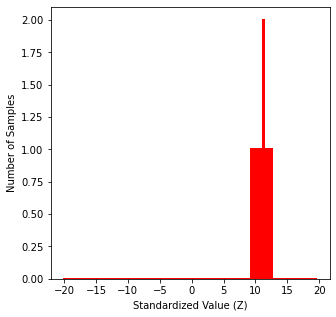

In [6]:
### Next let's calculate the global warming in the first ensemble member over a given time period.
### Our end goal is compare this warming to the 1850 control run and assess if the warming is statistically significant.

### Start by standardizing member 1 data using the 1850 control mean and standard deviation
startyear=2020
endyear=2030
nyrs=(endyear-startyear)
print("nyears:"+np.str(nyrs))
gts_mem1=gts.sel(member=1).sel(year=slice(startyear,endyear-1))
print(gts_mem1)
gts_mem1_norm=(gts_mem1-gts_1850_mean)/gts_1850_std

print("Standardized mean CESM LE member 1:")
print(np.round(np.mean(gts_mem1_norm).values,2))

## plot a histogram to see the range of values
xinc = np.arange(-20,20,.25)
hx=np.histogram(gts_mem1_norm,xinc);
plt.bar(hx[1][:-1],hx[0],edgecolor = 'r', color = 'k', width = .25, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

## another histogram option to try (might be deprecated)
#xinc = np.arange(-20,20,.25)
#plt.hist(gts_mem1_norm,xinc)
#plt.ylabel('Number of Samples')
#plt.xlabel('Standardized Value (Z)')

In [7]:
## What is the probability that the mean annual global mean temperature was X assuming no global warming?
## Test sample mean is equal to the population mean (null hypothesis)
## Assume that the Global Mean Annual Temperature is standard normal. 

## Using Barnes equation (83) to calculate probability using z-statistic
sample_mean=np.mean(gts_mem1_norm).values
print('sample_mean:',np.str(np.round(sample_mean,2)))
population_mean=gts_1850_norm_mean
population_std=gts_1850_norm_std
xstd=population_std/np.sqrt(nyrs)
z=(sample_mean-population_mean)/xstd
print("Z-statistic:")
print(np.round(z,2))
print("Probability (percent):")
prob=(1-stats.norm.cdf(z))*100
print(np.round(prob,2))

## Using Barnes equation (96) to calculate probability using the t-statistic
sample_mean=np.mean(gts_mem1_norm).values
sample_std=np.std(gts_mem1_norm).values
print("T-statistic:")
t=(sample_mean-population_mean)/(sample_std/(np.sqrt(nyrs-1)))
print(np.round(t,2))
print("Probability (percent):")
prob=(1-stats.t.cdf(t,nyrs-1))*100
print(np.round(prob,2))

print('ttest function from python')
#stats.ttest_ind(gts_1850_norm,gts_mem1_norm)
print(stats.ttest_ind(gts_mem1_norm,gts_1850_norm,equal_var = False)) #When equal_var is false (defaults to true),
#this means that the underlying population variances are NOT equal and this function then uses Welch's T-test
print('Cannot reject the null hypthesis.')

sample_mean: 11.18
Z-statistic:
35.36
Probability (percent):
0.0
T-statistic:
37.12
Probability (percent):
0.0
ttest function from python
Ttest_indResult(statistic=37.01131288736265, pvalue=3.026548718423069e-11)
Cannot reject the null hypthesis.


In [8]:
### LEARNING GOAL #3 - Calculate confidence intervals on CESM-LE global warming using z-statistic and t-statistic

### Use the code below to calculate how much global warming occurred over the 21st century in both 
### individual ensemble members and the ensemble mean.

## Compare 21st century global warming: one member vs. ensemble mean
gw_mem1=gts.sel(member=1).sel(year=slice(2080,2100)).mean("year")- \
        gts.sel(member=1).sel(year=slice(2000,2020)).mean("year")
gw_mean=(gts.sel(year=slice(2080,2100)).mean("year").mean("member"))- \
        (gts.sel(year=slice(2000,2020)).mean("year").mean("member"))
print(np.round(gw_mem1.values,2))
print(np.round(gw_mean.values,2))

3.7
3.63


In [9]:
## Next - let's calculate emsemble statistics about 21st century global warming
nmembers=30
temp=(gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")-\
      gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year"))
gw_mean_mem=temp.mean("member")
gw_std_mem=temp.std("member")
gw_min_mem=temp.min("member")
gw_max_mem=temp.max("member")
print("mean: ",np.str(np.round(gw_mean_mem.values,2)))
print("stdev: ",np.str(np.round(gw_std_mem.values,2)))
print("min: ",np.str(np.round(gw_min_mem.values,2)))
print("max: ",np.str(np.round(gw_max_mem.values,2)))

mean:  3.63
stdev:  0.06
min:  3.51
max:  3.75


In [10]:
### Let's add confidence intervals to the estimated global warming
### Specifically - we'll compare confidence intervals calculated using t-statistic and z-statistic

#### Calculate the 95% and 99% confidence limits on the 21st century warming using t-statistic
#### Assume that the global warming is normally distributed.
N=nmembers
df=N-1

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
low_limit95=gw_mean_mem-tstat95*(gw_std_mem/np.sqrt(nmembers-1))
high_limit95=gw_mean_mem+tstat95*(gw_std_mem/np.sqrt(nmembers-1))
print("95% confidence limits - t-statistic")
print(np.round(low_limit95.values,2))
print(np.round(high_limit95.values,2))

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
tstat99=stats.t.ppf(0.995,df)
low_limit99=gw_mean_mem-tstat99*(gw_std_mem/np.sqrt(nmembers-1))
high_limit99=gw_mean_mem+tstat99*(gw_std_mem/np.sqrt(nmembers-1))
print("99% confidence limits - t-statistic")
print(np.round(low_limit99.values,2))
print(np.round(high_limit99.values,2))

#### Calculate the 95% and 99% confidence limits on the 21st century warming using z-statistic
#### Assume that the global warming is normally distributed.

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
zstat95=stats.norm.ppf(0.975)
low_limit95=gw_mean_mem-zstat95*(gw_std_mem/np.sqrt(nmembers))
high_limit95=gw_mean_mem+zstat95*(gw_std_mem/np.sqrt(nmembers))
print("95% confidence limits - z-statistic")
print(np.round(low_limit95.values,2))
print(np.round(high_limit95.values,2))

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
zstat99=stats.norm.ppf(0.995)
low_limit99=gw_mean_mem-zstat99*(gw_std_mem/np.sqrt(nmembers))
high_limit99=gw_mean_mem+zstat99*(gw_std_mem/np.sqrt(nmembers))
print("99% confidence limits - z-statistic")
print(np.round(low_limit99.values,2))
print(np.round(high_limit99.values,2))

95% confidence limits - t-statistic
3.61
3.66
99% confidence limits - t-statistic
3.6
3.67
95% confidence limits - z-statistic
3.61
3.66
99% confidence limits - z-statistic
3.6
3.66


[3.695221  3.636963  3.652832  3.6441956 3.634613  3.5675354 3.6606445
 3.7267761 3.5054932 3.6834412 3.5503845 3.5212708 3.5517578 3.6859741
 3.619995  3.7277527 3.6286316 3.541504  3.5733337 3.5706787 3.6762085
 3.6142273 3.6184998 3.6961365 3.6150513 3.6669922 3.6224976 3.688324
 3.7549744 3.6689758]
[3.5  3.55 3.6  3.65 3.7  3.75]


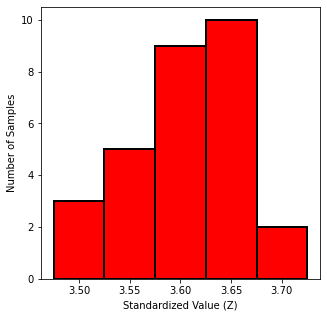

In [11]:
#### plot a histogram of global warming - Was normal distribution a good approximation?
gw_allmem=gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")- \
        gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year")
print(gw_allmem.values)

## plot a histogram to see the range of values
xinc = np.arange(3.5,3.8,.05)
print(xinc)
hx=np.histogram(gw_allmem,xinc)
plt.bar(hx[1][:-1],hx[0],edgecolor = 'k', color = 'r', width = .05, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

### another histogram option
#xinc = np.arange(3.5,3.8,.05)
#plt.hist(gw_allmem,xinc);
#plt.ylabel('Number of Samples');
#plt.xlabel('Standardized Value (Z)');

In [12]:
#### What if you you only had 6 ensemble members?  Estimate your confidence interval using a t-statistic.
## Calculate statistics for the 21st century global warming
nmembers=6
temp=(gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")-\
      gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year"))
print(temp)
gw_mean_mem=temp.mean("member")
gw_std_mem=temp.std("member")
gw_min_mem=temp.min("member")
gw_max_mem=temp.max("member")

print("mean: ",np.str(np.round(gw_mean_mem.values,2)))
print("stdev: ",np.str(np.round(gw_std_mem.values,2)))
print("min: ",np.str(np.round(gw_min_mem.values,2)))
print("max: ",np.str(np.round(gw_max_mem.values,2)))

<xarray.DataArray 'gts_ann_allcesmle' (member: 6)>
array([3.695221 , 3.636963 , 3.652832 , 3.6441956, 3.634613 , 3.5675354],
      dtype=float32)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6
mean:  3.64
stdev:  0.04
min:  3.57
max:  3.7


In [13]:
#### Calculate the 95% and 99% confidence limits on the 21st century warming using t-statistic
#### Assume that the global warming is normally distributed.  (See page 18 of Barnes notes)
N=nmembers
df=N-1

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
low_limit95=gw_mean_mem-tstat95*(gw_std_mem/np.sqrt(nmembers-1))
high_limit95=gw_mean_mem+tstat95*(gw_std_mem/np.sqrt(nmembers-1))
print("95% confidence limits - t-statistic")
print(low_limit95.values)
print(high_limit95.values)

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
tstat99=stats.t.ppf(0.995,df)  #### FIXED - this said stats.norm.ppf instead of stats.t.ppf
low_limit99=gw_mean_mem-tstat99*(gw_std_mem/np.sqrt(nmembers-1))
high_limit99=gw_mean_mem+tstat99*(gw_std_mem/np.sqrt(nmembers-1))
print("99% confidence limits - t-statistic")
print(low_limit99.values)
print(high_limit99.values)

95% confidence limits - t-statistic
3.5952689933866235
3.681851119986179
99% confidence limits - t-statistic
3.5706549020445166
3.706465211328286
